# 분류의 평가

필요한 패키지와 라이브러리 설치하고 사용할 함수를 먼저 정의한다.


In [ ]:
# 한글 폰트가 깨질 때 사용 - 런타임 메뉴에서 다시 시작 및 모두 실행 선택. (출처: https://teddylee777.github.io/colab/colab-korean)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# pandas 라이브러리의 탐색적 데이터 분석 도구(explanatory data analysis tool, profiling)를 설치한다.
!pip install -U pandas-profiling

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

In [3]:
from matplotlib import rc
%matplotlib inline

plt.rc('font', family='NanumBarunGothic') # clolab 에서 한글 사용 
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams["figure.figsize"] = (10,7)   # 그림 크기 조정

In [4]:
#기계학습 모형
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# 기계학습 평가 도구
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split



In [5]:
# 표준화 함수
def standarize(x):
  return (x - np.mean(x))/np.std(x)

## 분류의 평가 기준 

앞 절에서 이항 변수(binary variable)을 예측하는 분류 방법들을 알아보았다.

분류에 사용된 기계학습 모형이 얼마나 분류를 잘 수행하였는지 평가하는 기준이 있어야 서로 다른 방법들을 비교할 수 있다. 

학습데이터에 포함된 반응변수의 값 $y$ 과 적합된 모형을로 부터 에측된 값 $\hat y$ 을 비교하여 일치하는 비율을 **예측의 정확성(prediction accuracy)** 이라고 하며 예측모형을 평가하는 가장 기본적인 측조이다.

$$ \text{Accuracy } = \frac{\text{ number of records for which } y_i = \hat y_i}{n} $$

## 학습 데이터와 평가 데이터


예측의 정확성을 계산할 때 주의할 점은 모형의 적합에 사용된 데이터와 평가를 수행하는 데이터가 일치하면 모형의 실제 정확성을 과대 추정할 수 있는 위험성이 있다는 것이다.

우리가 자신에 대한 평가를 하는 경우를 생삿해 보자. 내가 나 자신을  평가하면  다른 사람들이 나를 평가하는 것보다 더 좋은 평가를 내릴 위험성이 크다는 의미이다. 

따라서 모형의 공정하고 정확한 평가를 수행하기 위해서는 사용할 수 잇는 데이터를 다음과 같이 두 개로 나누어야 한다.

- **학습 데이터(training data)** : 모형을 적합하고 계수를 추정하는데 사용되는 데이터
- **검증 데이터(test data, validation data)** : 모형의 예측 능력을 평가하는 데이터



![학습데이터, 검증데이터](https://scikit-learn.org/stable/_images/grid_search_workflow.png)


## 심장병 데이터

심혈관 질환(Cardiovascular disease)은 전 세계 사망 원인 1위이며 매년 약 1,790만 명이 사망하며 이는 전 세계 사망의 31%를 차지한다. 심혈관 질환으로 인한 사망 5건 중 4건은 심장마비와 뇌졸중으로 인한 것이며, 이 중 3분의 1은 70세 미만에서 조기에 발생한다. 

이 절에서 이용할 자료는 [Kaggle](https://www.kaggle.com/fedesoriano/heart-failure-prediction?select=heart.csv)
 에서 얻을 수 있는 공공 데이터 세트이며 심장 질환을 예측하는 데 사용할 수 있는 11가지 변수가 포함된 자료이다.

자료를 다운로드 하여 데이터프레임 `heart` 에 저장하자.

In [6]:
url = "https://ilovedata.github.io/teaching/bigdata2/data/heart.csv"
heart = pd.read_csv(url)

In [7]:
heart['FastingBS'] = heart['FastingBS'].astype(int)
heart['HeartDisease'] = heart['HeartDisease'].astype(int)

In [8]:
heart.shape

(918, 12)

In [9]:
heart.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


데이터프레임 `heart` 의 각 열에 대한 설명은 다음과 같다. 마지막 변수 `HeartDisease` 가 반응변수이며 나머지는 모두 설명변수이다.

| Feature | Description |
| :- | :- |
| Age | 연령 (연) |
| Sex | 성별 (M: 남성, F: 여성) |
| ChestPainType | 가슴의 통증 분류 [TA: 전형적인 협심증 통증(Typical Angina), ATA: 비전형적 협심증(Atypical Angina, NAP: 비협심증 통증(Non-Anginal Pain), ASY: 없음) |
| RestingBP | 혈압 (mm Hg) |
| Cholesterol | 콜레스테롤 (mm/dl) |
| FastingBS | 공복혈당 (1: 만약 공복혈당 > 120 mg/dl, 0: 아니면) |
| RestingECG | 심전도 결과 (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria) |
| MaxHR | 최대 심박수 (60 과 202 사이의 숫자) |
| ExerciseAngina | 운동 유발성 협심증 (Y: 예, N: 아니오) |
| Oldpeak | oldpeak = ST (Numeric value measured in depression) |
| ST_Slope | the slope of the peak exercise ST segment (Up: upslo ping, Flat: flat, Down: downsloping) |
| HeartDisease | 결과 (1: 심장병 있음, 0: 심장병 없음) |


각 변수에 대한 분포를 구하고 기초 통계량과 상관관계를 살펴 보자. 데이터에 대한 탐색적 분석을 위하여 `pandas` 라이브러리에서 제공하는 `profile_report()` 메소드를 사용해보자. `profile_report()`는 여러 가지 다양한 통계량을 일목요연하게 HTML 형식으로 나타내어 준다. `profile_report()` 를 이용하려면 터미널에서 다음과 같이 패키지를 설치해야 한다. 

```
pip install -U pandas-profiling
```


In [ ]:
# 다음 코드는 꼭 colab 에서 실행시키세요

heart.profile_report()


## 데이터 전처리

데이터프레임 `heart`에는 연속형 설명변수와 범주형 설명변수가 같이 포함되어 있다. 아래 코드에서 `info()` 메소드는 데이터프레임의 야에 대한 자료의 형식을 나타내는 것이다. 형식 `Dtype` 이 `object` 로 나타나는 열이 범주형 변수이다.


In [11]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


설명변수가 범주형인 경우 기계학습 모형을 이용하기 위해서는 각 범주형 변수에 대한 가변수(dummy variable)을 만들어 주어야 한다. 가변수는 범주의 개수보다 하나 작은 개수의  연속형 변수들를 만들어 주는 것이다.

예를 들어 변수 `RestingECG` 는 `Normal`, `LVS`, `ST`  세 가지 범주로 구성되어 있다면 두 개의 연속형 변수 `RestingECG_Normal`, `	RestingECG_ST`를 만들어 다음과 같이 범주를 나타내는 것이다.


| 원래변수 `RestingECG` 의 값 | `RestingECG_Normal` | `	RestingECG_ST`|
|:------:|:------:|:------:|
|`Normal` |   1 |  0 |
|`ST` | 0 | 1 |
|`LVS` | 0 | 0 |

먼저 메소드 `select_dtypes(include=object).columns`를 이용하여 범주형 변수로 구성된 모든 열의 이름을 `cat_col_names`에 저장한다.

In [12]:
# 범주형 변수로 구성된 모든 열의 이름 추출
cat_col_names = heart.select_dtypes(include=object).columns
cat_col_names


Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

다음으로 메소드 `get_dummies(heart, cat_col_names, drop_first=True)` 를 사용하여 가변수를 생성하자. 가변수를 포함한 데이터프레임은 `heart2` 에 저장한다.  

In [13]:
# 범주형변수에 대한 가변수를 생성하고 새로운 데이터 프레임에 저장한다. 
heart2 = pd.get_dummies(heart, columns=cat_col_names, drop_first=True)  
heart2.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


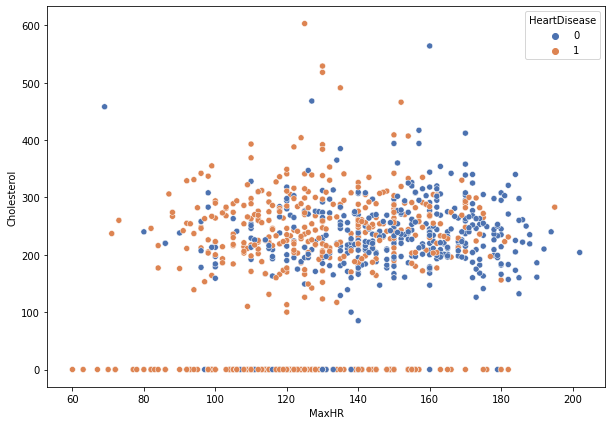

In [14]:
sns.scatterplot(data=heart2, x= "MaxHR", y= "Cholesterol", hue="HeartDisease", palette="deep")


이제 앞에서 언급한 것처럼 전체 데이터를  학습 데이터와 검증 데이터로 나눌 것이다.

먼저 반응변수 `HeartDisease` 와 독립변수들을 나누어서 저장하자. 

In [15]:
# 독립변수들 
X =  heart2.drop(columns='HeartDisease')
# 표준화
X = np.array(X.apply(standarize, axis=0))

In [16]:
# 반응변수 
y = heart['HeartDisease']

이제 반응변수 행렬 `y` 와 독립변수 행렬 `X` 를 각각 학습데이터와 검증데이터로 나눈다.

학습데이터와 검증데이터로 나눈 떄는 함수 `train_test_split()` 을 사용한다. `test_size` 는 0과 1 사이의 비율이며 검증 데이터가 전체 자료에서 차지하는 비율을 지정한다. 검증데이터는 원 자료에서 임의로 추출된다.

아래 파이썬 코드는 `heart2` 데이처프레임에서 30% 의 자료를 검증 데이터로 추출하는 것이다.

In [17]:
# 학습데이터와 검증데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=112)

In [18]:
X_train.shape

(642, 15)

## 모형의 적합


이제 학습 데이터를 이용하여 로지스틱 회귀 모형을 적합시켜 보자.

In [19]:
# 로지스틱 회귀모형 정의
heart2_logistic_model = LogisticRegression()

# 모형적합
heart2_logistic_model.fit(X_train, y_train)

LogisticRegression()

로지스틱 회귀모형을 추정된 계수를 보자.

In [20]:
# beta0
b0 = heart2_logistic_model.intercept_[0]

# beta1, beta2 
heart2_logistic_model.coef_.T

b0

0.29629841844864596

In [21]:
heart2_logistic_model.coef_.T

array([[-0.05229291],
       [ 0.06589351],
       [-0.50606793],
       [ 0.46424207],
       [-0.22069989],
       [ 0.37807856],
       [ 0.71507128],
       [-0.6929317 ],
       [-0.70807937],
       [-0.36006924],
       [-0.09134031],
       [-0.03307451],
       [ 0.50517422],
       [ 0.78446352],
       [-0.50244784]])

## 예측의 정확성

이제 마지막으로 검증 데이터에 적합된 모형을 사용하여 예측의 정확성를 구해보자. 예측의 정확성 비율은 함수 `accuracy_scrore(y_true, y_new)`를 이용하여 계산한다. 


In [22]:
# 검증 데이터에 대한 예측값 생성 
y_pred = heart2_logistic_model.predict(X_test)
# 에측의 정확성 계산
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

Accuracy: 0.8406


In [23]:
df_test = pd.DataFrame({'y_true':y_test, 'y_pred': y_pred })
df_test.head(10)

,y_true,y_pred
361,1,1
270,0,0
459,0,1
852,1,1
175,1,1
618,0,1
759,1,0
26,0,1
303,1,1
506,1,1


참고로 검증자료가 없고 전체 자료를 학습 데이터로 이용하여 모형을 적합하고 동일한 학습데이터로 예측의 정확성을 계산해 보자. 

In [24]:
# 로지스틱 회귀모형 정의
heart2_logistic_model_A = LogisticRegression()

# 전체 데이터를 이용한 모형적합
heart2_logistic_model_A.fit(X, y)

LogisticRegression()

In [25]:
# 전체 데이터에 대한 예측값 생성 
y_pred_A = heart2_logistic_model.predict(X)
# 예측의 정확성 계산
print('Accuracy: %.4f' % accuracy_score(y, y_pred_A))

Accuracy: 0.8693


위의 결과에서 본 것처럼 독립적인 검증 데이터로 구한 예측의 정확성이 동일한 학습데이터로 부터 구한 예측의 정확성보다 일반적으로  작게 나타난다. 

다시 강조하면 독립적인 검증 데이터로 구한 예측의 정확성이 더 정확한 측도이다. 

## 기계학습 방법의 평가

이제 앞 절에서 다룬 4개의 기계학습 모형들을 이용하여 심장병 예측에 대한 예측의 정확도를 비교해 보자.

In [26]:
# 기계학습 모형의 정의
model_logistic = LogisticRegression()
model_tree = DecisionTreeClassifier(max_depth=3)
model_knn = KNeighborsClassifier(n_neighbors=7)
model_svm = SVC(gamma=0.1, kernel="rbf", probability=True)

# 모형의 적합
model_logistic.fit(X_train, y_train)
model_tree.fit(X_train, y_train)
model_knn.fit(X_train, y_train)
model_svm.fit(X_train, y_train)

SVC(gamma=0.1, probability=True)

In [27]:
df_accuracy = pd.DataFrame({'model': ["Logisitc","Decision Tree", "KNN", "Kernel SVM"], 'accuracy': np.zeros(4)})

for i, clf in enumerate([ model_logistic, model_tree, model_knn, model_svm]):

    y_pred = clf.predict(X_test)
    df_accuracy.iloc[i,1] = accuracy_score(y_test, y_pred)
    
df_accuracy    

,model,accuracy
0,Logisitc,0.840580
1,Decision Tree,0.804348
2,KNN,0.833333
3,Kernel SVM,0.865942


위의 결과를 보면 서포트 벡터 머신이 가장 좋은 예측의 정확도를 보인다.

## 정리

분류에서 예측을 하는 절차를 정리하면 다음과 같다.

1. 데이터의 전처리
  + 반응변수를 1과 0으로 코딩
  + 연속형 설명변수를 표준화
  + 범주형 설병변수에 대한 가변수 생성 
  + 데이터를 학습데이터와 검증데이터로 분리 (`X_train, X_test, y_train, y_test`) 
2. 예측 모형의 정의
  + 예:
```
my_model = LogisticRegression()
```

3. 학습 데이터를 이용한 모형의 적합
  + 예:
```
my_model.fit(X_train, y_train)
```

4. 검증 데이터를 이용한 모형의 평가 
  + 예측의 정확도 계산
  + 예:
```
y_pred = my_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
```    